In [1]:
from string import punctuation
import os
from os import listdir
from collections import Counter
from nltk.corpus import stopwords

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# turn a doc into clean tokens
def clean_doc(doc):
	# split into tokens by white space
	tokens = doc.split()
	# remove punctuation from each token
	table = str.maketrans('', '', punctuation)
	tokens = [w.translate(table) for w in tokens]
	# remove remaining tokens that are not alphabetic
	tokens = [word for word in tokens if word.isalpha()]
	# filter out stop words
	stop_words = set(stopwords.words('english'))
	tokens = [w for w in tokens if not w in stop_words]
	# filter out short tokens
	tokens = [word for word in tokens if len(word) > 1]
	return tokens

# load doc and add to vocab
def add_doc_to_vocab(filename, vocab):
	# load doc
	doc = load_doc(filename)
	# clean doc
	tokens = clean_doc(doc)
	# update counts
	vocab.update(tokens)

# load all docs in a directory
def process_docs_1(directory, vocab):
	# walk through all files in the folder
	for filename in listdir(directory):
		# skip files that do not have the right extension
		if not filename.endswith(".txt"):
			continue
		# create the full path of the file to open
		path = directory + '/' + filename
		# add doc to vocab
		add_doc_to_vocab(path, vocab)
# load all docs in a directory
def process_docs_2(directory, vocab):
	lines = list()
	# walk through all files in the folder
	for filename in listdir(directory):
		# skip files that do not have the right extension
		if not filename.endswith(".txt"):
			continue
		# create the full path of the file to open
		path = directory + '/' + filename
		# load and clean the doc
		line = doc_to_line(path, vocab)
		# add to list
		lines.append(line)
	return lines
# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
	# load the doc
	doc = load_doc(filename)
	# clean doc
	tokens = clean_doc(doc)
	# filter by vocab
	tokens = [w for w in tokens if w in vocab]
	return ' '.join(tokens)


# save list to file
def save_list(lines, filename):
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()


# load vocabulary
vocab_filename = 'aclImdb/imdb.vocab'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)
positive_docs = process_docs_2('aclImdb/train/pos', vocab)
negative_docs = process_docs_2('aclImdb/train/neg', vocab)
train_docs = negative_docs + positive_docs
print(len(vocab))
doc_size = len(positive_docs)
print(doc_size)
print(len(train_docs))

89527
12500
25000


In [2]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D
from keras.layers import LSTM
from keras.layers.wrappers import Bidirectional
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# training
epochs = 5

# vector 
n_dim = 128 
n_unique_words = 10000 
max_review_length = 200
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# LSTM
n_lstm_1 = 256
n_lstm_2 = 256
drop_lstm = 0.2

# create the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_docs)
encoded_docs = tokenizer.texts_to_sequences(train_docs)
print(len(encoded_docs))

Using TensorFlow backend.


25000


In [3]:
x_train = pad_sequences(encoded_docs, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

In [4]:
print(len(x_train))

25000


In [5]:
y_train = np.array([0 for _ in range(doc_size)] + [1 for _ in range(doc_size)])
print(len(y_train))

25000


In [6]:
# load all test reviews
positive_docs = process_docs_2('aclImdb/test/pos', vocab)
negative_docs = process_docs_2('aclImdb/test/neg', vocab)
test_docs = negative_docs + positive_docs
encoded_docs = tokenizer.texts_to_sequences(test_docs)
x_valid = pad_sequences(encoded_docs, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
y_valid = np.array([0 for _ in range(doc_size)] + [1 for _ in range(doc_size)])
print(len(x_valid))
print(len(y_valid))

25000
25000


In [7]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))
model.add(Bidirectional(LSTM(n_lstm_1, dropout=drop_lstm, return_sequences=True)))
model.add(Bidirectional(LSTM(n_lstm_2, dropout=drop_lstm)))
model.add(Dense(1, activation='sigmoid'))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          1280000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 512)          788480    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 3,643,905
Trainable params: 3,643,905
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
# checkpoint
output_dir = "model_weights/trainable_emb_lstm_stacked_Bi_Directional"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
filepath=output_dir+"/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [11]:
history = model.fit(x_train, y_train, epochs=epochs, verbose=1, callbacks=callbacks_list, validation_data=(x_valid, y_valid))




Train on 25000 samples, validate on 25000 samples
Epoch 1/5





25000/25000 [==============================] - 802s 32ms/step - loss: 0.5076 - acc: 0.7457 - val_loss: 0.5870 - val_acc: 0.6953

Epoch 00001: val_acc improved from -inf to 0.69532, saving model to model_weights/trainable_emb_lstm_stacked_Bi_Directional/weights-improvement-01-0.70.hdf5
Epoch 2/5
25000/25000 [==============================] - 799s 32ms/step - loss: 0.4302 - acc: 0.8077 - val_loss: 0.3372 - val_acc: 0.8495

Epoch 00002: val_acc improved from 0.69532 to 0.84952, saving model to model_weights/trainable_emb_lstm_stacked_Bi_Directional/weights-improvement-02-0.85.hdf5
Epoch 3/5
25000/25000 [==============================] - 799s 32ms/step - loss: 0.2666 - acc: 0.8940 - val_loss: 0.3525 - val_acc: 0.8517

Epoch 00003: val_acc improved from 0.84952 to 0.85168, saving model to model_weights/trainable_emb_lstm_stacked_Bi_Directional/weights-improvement-03-0.85.hdf5
Epoch 4/5
25000/25000 [=========================

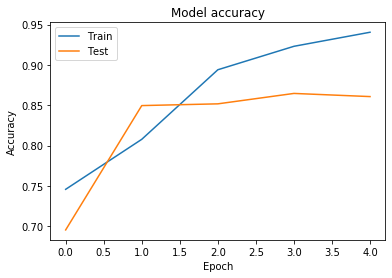

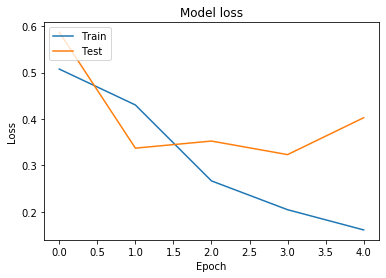

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [14]:
model.load_weights(output_dir+"/weights-improvement-04-0.86.hdf5")

In [15]:
y = model.predict_proba(x_valid)

(array([9076., 1614., 1007.,  798.,  758.,  707.,  658.,  879., 1560.,
        7943.]),
 array([0.00808924, 0.1066327 , 0.20517616, 0.3037196 , 0.40226308,
        0.50080657, 0.59935   , 0.69789344, 0.7964369 , 0.8949804 ,
        0.99352384], dtype=float32),
 <a list of 10 Patch objects>)

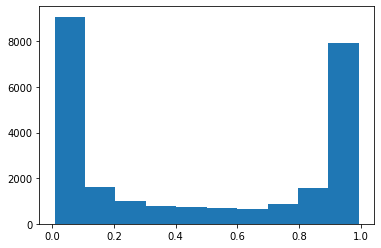

In [16]:
plt.hist(y)

In [17]:
score = model.evaluate(x_valid, y_valid, verbose=0)
print("Accuracy: %.2f%%" % (score[1]*100))

Accuracy: 86.46%


In [18]:
#area under curve score
"{:0.2f}".format(roc_auc_score(y_valid, y)*100)

'94.00'